# Project_3: Linear Regressions with Interactions
## Author: Wing Yan Sang
## Date: 11/10/2017

<p><a name="sections"></a></p>


## Sections

- <a href="#skewness">Skewness</a><br>
- <a href="#scaling">Scaling</a><br>
- <a href="#dummification">Dummification</a><br>
- <a href="#splitting">Splitting Data</a><br>
- <a href="#EDA">EDA</a><br>
- <a href="#ridge">Ridge Regression</a><br> 
- <a href="#results_analy1">Analysis of Results</a><br> 
- <a href="#kaggle1">Kaggle Submission (Ridge)</a><br>
- <a href="#lasso">Lasso Regression</a><br>
- <a href="#kaggle2">Kaggle Submission (Lasso)</a><br>
- <a href="#results_analy2">Analysis of Results</a><br> 

In [209]:
#### Loading the packages to be used
from __future__ import print_function 
from pandas.core import datetools
import pandas as pd
import numpy as np
from scipy import stats

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge, Lasso, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

import statsmodels.api as sm
from  statsmodels.genmod import generalized_linear_model

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns


In [210]:
# Read in csv files

inter_train = pd.read_csv('Train_Data_Interactions.csv')
inter_test = pd.read_csv('Test_Data_Interactions.csv')

pd.set_option('display.max_columns', 500)

In [331]:
#separate out SalePrice
y = inter_train['SalePrice']
y_log = np.log1p(y)

In [212]:
# Separate out interaction column names
filter_col = ['BsmtQual + BsmtCond', 'ExterQual + ExterCond', 'GarageQual + GarageCond', 'Heating + HeatingQC',
             'HighQualFinishedSF', 'OverallQual * TotalBaths', 'OverallQual * TotalSF', 
              'OverallQual + OverallCond', 'SaleType + SaleCondition', 'TotalBaths * TotalSF', 
                'TotalFinishedSF', 'TotalSF']

#Seperate out numeric column names
num_col = ['HighQualFinishedSF','OverallQual * TotalBaths', 'OverallQual * TotalSF', 'TotalBaths * TotalSF',
            'TotalFinishedSF', 'TotalSF']

#separate out categorical column names
cat_col = ['BsmtQual + BsmtCond', 'ExterQual + ExterCond', 'GarageQual + GarageCond', 'Heating + HeatingQC',
              'OverallQual + OverallCond', 'SaleType + SaleCondition']


In [213]:
#Separate out interaction columns for training and test sets

interact_train = inter_train[filter_col]
interact_test = inter_test[filter_col]

<p><a name="skewness"></a></p>
### Skewness

In [214]:
#Check skewness of numeric interaction columns in training set

for col in num_col:  
    print(interact_train[col].skew())
print (num_col)

#all numeric variables are skewed (>1) except for OverallQual*TotalSF
skewed_col =  ['HighQualFinishedSF', 'OverallQual * TotalSF', 'TotalBaths * TotalSF',
            'TotalFinishedSF', 'TotalSF']

1.77669962724
0.757520454513
2.43960828471
2.5978969391
2.16688958659
1.77802918539
['HighQualFinishedSF', 'OverallQual * TotalBaths', 'OverallQual * TotalSF', 'TotalBaths * TotalSF', 'TotalFinishedSF', 'TotalSF']


In [215]:
#unskew data
df = interact_train.copy()
for col in skewed_col:
    df[col] = np.log(df[col])

#print out skewness after
for col in skewed_col:  
    print(df[col].skew())

#set interact_train equal to df
interact_train = df
del df


-0.349581745014
-0.519875750991
-0.371297480333
-0.0447770630648
-0.344751617274


In [216]:
#Check skewness of numeric interaction columns in test set
for col in num_col:  
    print(interact_test[col].skew())
print (num_col)

1.20801389456
0.888449082964
1.80860669873
1.83397210173
1.47328679178
1.20277845129
['HighQualFinishedSF', 'OverallQual * TotalBaths', 'OverallQual * TotalSF', 'TotalBaths * TotalSF', 'TotalFinishedSF', 'TotalSF']


In [217]:
#unskew data
df = interact_test.copy()
for col in skewed_col:
    df[col] = np.log(df[col])

#print out skewness after
for col in skewed_col:  
    print(df[col].skew())

#set inter_test equal to df
interact_test = df
del df


-0.390648305631
-0.610007620765
-0.332015751407
-0.107079314333
-0.377444036882


<p><a name="scaling"></a></p>
### Scaling

In [218]:
#Scale numeric variables using normal distribution. Scale it according to training and apply to both 
#training and test sets

C =interact_train.copy()
D =interact_test.copy()
scaler = preprocessing.StandardScaler()

scaled_df =pd.DataFrame()
for col in num_col: 
    C[col] = scaler.fit_transform(interact_train[col].values.reshape(-1,1))
    D[col] = scaler.transform(interact_test[col].values.reshape(-1,1))

interact_train = C
interact_test = D

In [219]:
del C, D

In [220]:
# Combine training and test interactions
all_data = pd.concat([interact_train, interact_test])

<p><a name="dummification"></a></p>
### Dummification

In [221]:
#Dummify categorical variables

#First create separate data frame with just categoricals

cat_df = all_data[cat_col]

#Dummify the categoricals
cat_df = pd.get_dummies(cat_df, drop_first=True, dummy_na=False)
cat_df.head()

num_df = all_data[num_col]

all_data = pd.concat([num_df, cat_df], axis = 1)

In [222]:
del cat_df, num_df

<p><a name="splitting"></a></p>
### Create Two Data Frames: Train and Test

In [223]:
#Split all_sub dataset into two: train and test
train_index = len(interact_train)
train = all_data.iloc[:train_index, :]
test = all_data.iloc[train_index:, :]


<p><a name="EDA"></a></p>
### EDA

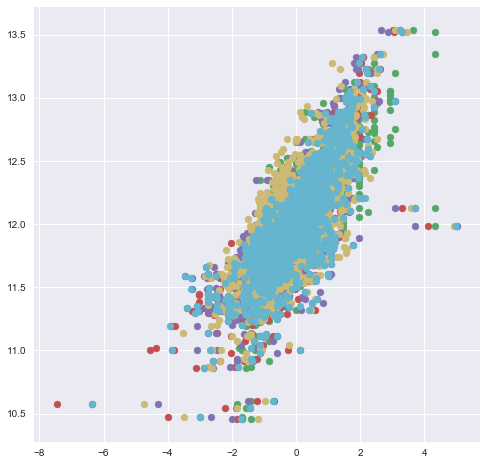

In [224]:
fig, ax = plt.subplots(figsize=(8,8))
for col in num_col: 
    plt.scatter(train[col], y_log)

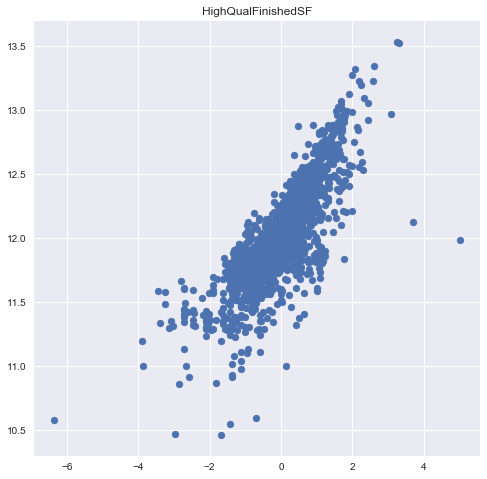

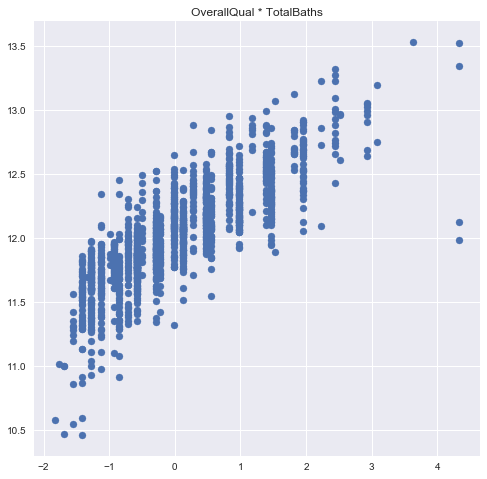

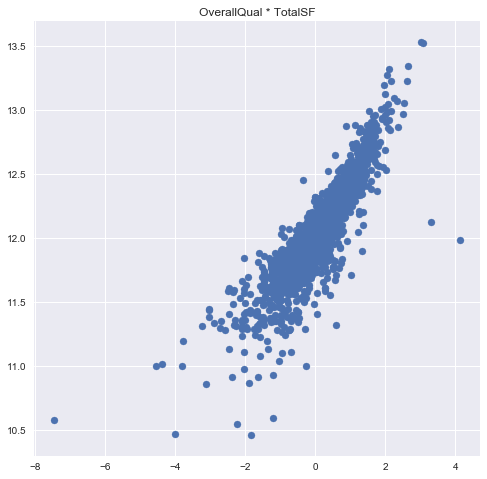

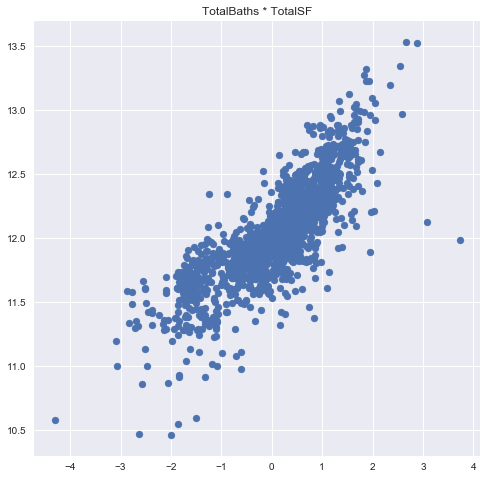

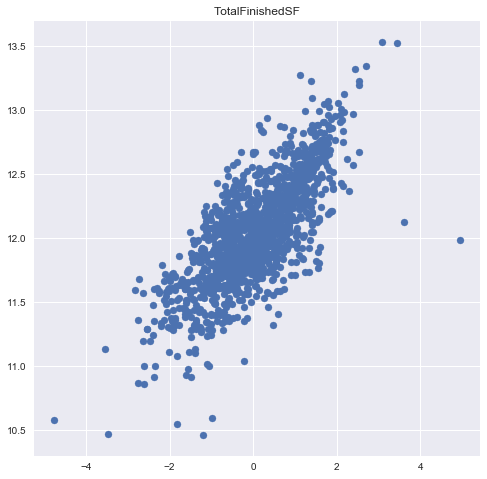

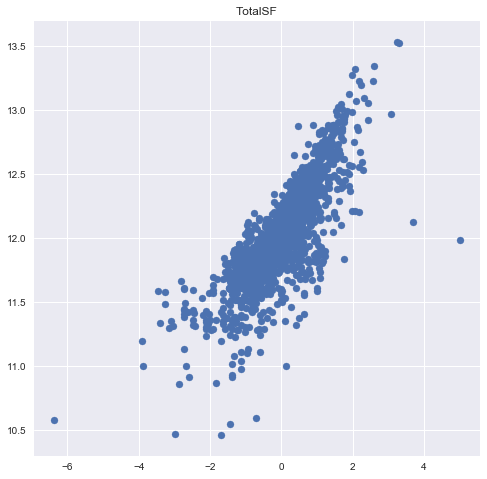

In [225]:
### Scatterplot of numeric variables against log sales price
    
for col in num_col: 
    plt.figure(figsize=(8, 8)) 
    plt.scatter(train[col], y_log) 
    plt.title(col)
    plt.show()

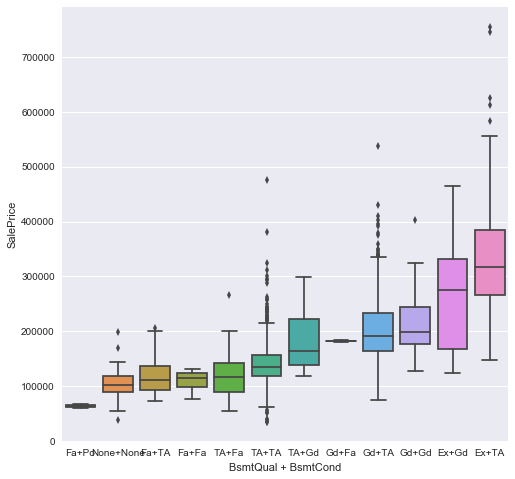

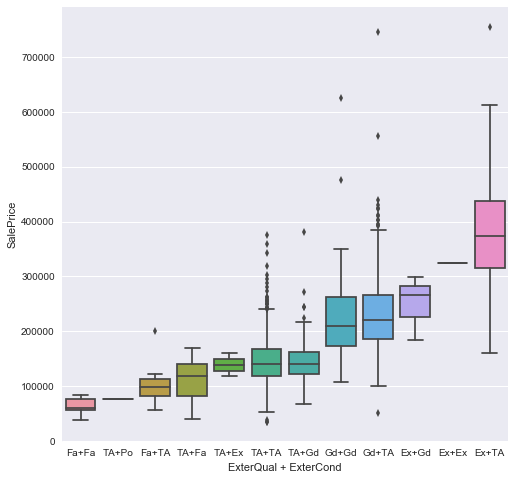

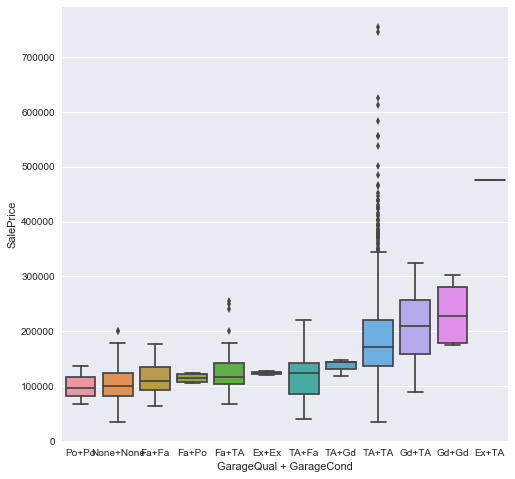

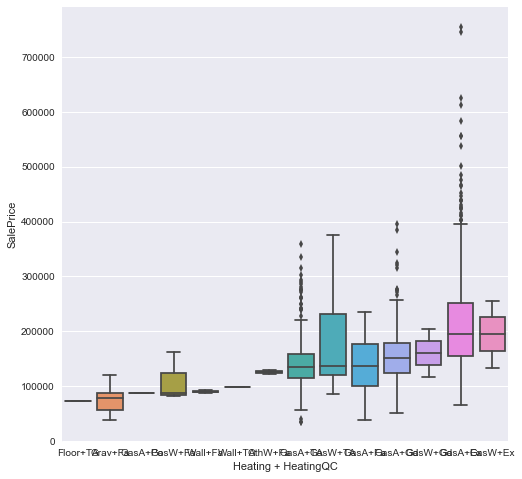

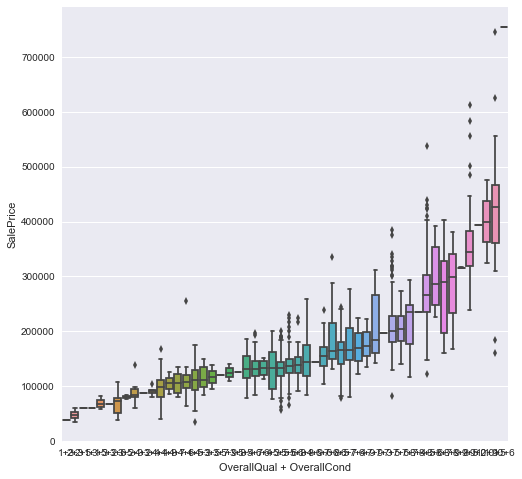

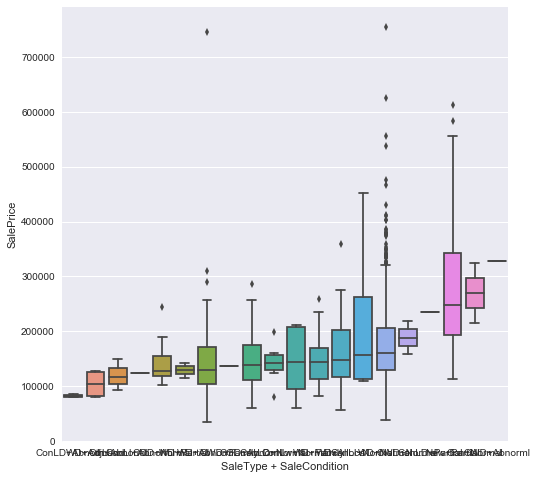

In [226]:
### Boxplots of categorical variables against log sales price
df = pd.concat([interact_train, y], axis = 1)

for col in cat_col:
    n = df.groupby([col])['SalePrice'].apply(np.median)
    n = n.sort_values()
    fig = plt.figure(figsize=(8, 8))
    sns.boxplot(y=df["SalePrice"], x=df[col], order = n.index)

<p><a name="ridge"></a></p>
### Ridge Regression
 - Perform Ridge regression of all variables along with Wing's Regression with 5 Variables 

In [332]:
#Remove outliers (observations 523, 1298)
df = train



In [333]:
#Read in data frame re-index column
train_wing = pd.read_csv('XTrain_Wing.csv')

In [334]:
#Combine with data frame of 5 variables from Wing's original regression. X will be the training set.
X = pd.concat([df, train_wing], axis = 1)

#Remove observations 523 and 1298

X = X.drop(X.index[[523,1298]])
y_log = y_log.drop(y_log.index[[523,1298]])

In [335]:
# Create training and test sets

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=8)

In [336]:
def rmse_cv(model,x, y):
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [337]:
model_ridge = Ridge()
alphas = np.logspace(0, 2, 100)
cv_ridge = [rmse_cv(Ridge(alpha = alpha), X_train, y_train).mean() 
            for alpha in alphas]

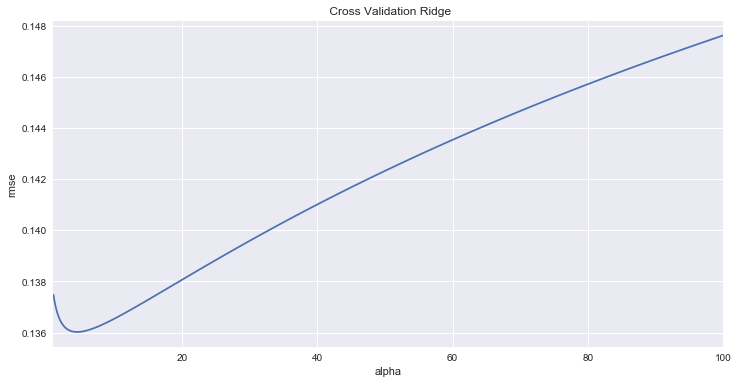

In [338]:
mpl.rcParams['figure.figsize'] = (12.0, 6.0)
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = " Cross Validation Ridge")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [339]:
#Best alpha and rmse
best =cv_ridge[cv_ridge == cv_ridge.min()]
best_alpha = best.index[0]
print(best_alpha)

4.43062145758


In [340]:
#Fitting to entire training subset using best alpha
Ridge_best = Ridge(alpha = best_alpha)
Ridge_best.fit(X_train, y_train)
print("Ridge training R-squared is: %f" %Ridge_best.score(X_train, y_train))

y_predicted_train = Ridge_best.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted_train)
rms_train = np.sqrt(mean_squared_error(y_train, y_predicted_train))
print("Ridge training RMSE is: %f" %rms_train)

Ridge training R-squared is: 0.908029
Ridge training RMSE is: 0.123603


In [341]:
#Test model against test set. 

y_predicted_test = Ridge_best.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = np.sqrt(mean_squared_error(y_test, y_predicted_test))
print("Ridge test R-squared is: %f" %Ridge_best.score(X_test, y_test))
print("Ridge test RMSE is: %f" %rms_test)

Ridge test R-squared is: 0.893183
Ridge test RMSE is: 0.118910


In [342]:
#Fitting to entire training set
Ridge_final = Ridge(alpha = best_alpha)
Ridge_final.fit(X, y_log)
print("Ridge R-squared on entire training set is: %f" %Ridge_best.score(X, y_log))

y_predicted = Ridge_final.predict(X)
mse = mean_squared_error(y_log, y_predicted)
rms = np.sqrt(mean_squared_error(y_log, y_predicted))
print("Ridg RMSE is: %f" %rms)

Ridge R-squared on entire training set is: 0.905740
Ridg RMSE is: 0.121406


In [343]:
Ridge_final.get_params()

{'alpha': 4.4306214575838814,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

<p><a name="kaggle1"></a></p>
### Submission to Kaggle (Ridge Regression)
    1. Make Predictions 
    2. Save Results

In [344]:
#add Test columns from Wing's original regression data frame to test
test_wing = pd.read_csv('XTest_Wing.csv') #this csv file contains 1460 rows. no outliers were removed
test_wing = test_wing.drop('const', axis = 1)

In [345]:
#combine the data frames
df = test
X_kaggle = pd.concat([df, test_wing], axis = 1)

In [346]:
#Make predictions
y_test = Ridge_final.predict(X_kaggle)
y_test = np.expm1(y_test)
y_test = pd.DataFrame({'SalePrice': y_test})

In [347]:
test_ID = pd.read_csv('test_ID.csv')

In [348]:
submission_4 = pd.concat([test_ID, y_test], axis = 1)

#write to csv file. Result: 0.13960
submission_4.to_csv("submission_4.csv", index=False)

In [349]:
submission_4.head()

,Id,SalePrice
0,1461,119891.457831
1,1462,157527.763774
2,1463,170051.509199
3,1464,178829.469423
4,1465,207756.242705


<p><a name="results_analy1"></a></p>
### Analysis of Ridge Regression Results

In [ ]:
### TO BE FILLED IN

<p><a name="lasso"></a></p>
### Lasso Regression


 - Perform Lasso regression of all variables along with Wing's Regression with 5 Variables

In [383]:
# Create training and test sets

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=8)

In [384]:
# LassoCV
from sklearn.model_selection import GridSearchCV
model = Lasso()
alphas = np.logspace(-3, 2, 100)
grid_param = [{'alpha': alphas}]
grid = GridSearchCV(estimator=model, param_grid=grid_param).fit(X_train, y_train)
print(grid)
print(grid.best_score_)
print(grid.best_estimator_.alpha)

GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([  1.00000e-03,   1.12332e-03, ...,   8.90215e+01,   1.00000e+02])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
0.877092938341
0.001


In [386]:
#Fitting to entire training subset using alpha = .001
Lasso_best = Lasso(alpha = .001)
Lasso_best.fit(X_train, y_train)
print("Lasso training R-squared is: %f" %Lasso_best.score(X_train, y_train))

y_predicted_train = Lasso_best.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted_train)
rms_train = np.sqrt(mean_squared_error(y_train, y_predicted_train))
print("Lasso training RMSE is: %f" %rms_train)

Lasso training R-squared is: 0.893470
Lasso training RMSE is: 0.133027


In [387]:
#Testing against test set
y_predicted_test = Lasso_best.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = np.sqrt(mean_squared_error(y_test, y_predicted_test))
print("Lasso test R-squared is: %f" %Lasso_best.score(X_test, y_test))
print("Lasso test RMSE is: %f" %rms_test)

Lasso test R-squared is: 0.893293
Lasso test RMSE is: 0.118849


In [388]:
#Fitting to entire training set. Improves again. 
Lasso_final = Lasso(alpha = .001)
Lasso_final.fit(X, y_log)
print("Lasso R-squared on entire training set is: %f" %Lasso_best.score(X, y_log))

y_predicted = Lasso_final.predict(X)
mse = mean_squared_error(y_log, y_predicted)
rms = np.sqrt(mean_squared_error(y_log, y_predicted))
print("Lasso RMSE is: %f" %rms)

Lasso R-squared on entire training set is: 0.893644
Lasso RMSE is: 0.130999


<p><a name="kaggle2"></a></p>
### Submission to Kaggle (Lasso Regression)
    1. Make Predictions 
    2. Save Results

In [392]:
#Make predictions
y_test = Lasso_final.predict(X_kaggle)
y_test = np.expm1(y_test)
y_test = pd.DataFrame({'SalePrice': y_test})

In [393]:
submission_5 = pd.concat([test_ID, y_test], axis = 1)

#write to csv file. Result: 0.14181
submission_5.to_csv("submission_5.csv", index=False)

<p><a name="results_analy2"></a></p>
### Analysis of Lasso Regression Results

In [ ]:
### TO BE FILLED IN